### **Auto Encoders**
Auto Encoders are kind of neural network or deep learning models which tries to compress the information hidded in one data to some less dimenssional vectors. There after the decoder of that architecture decodes the embedding/ encoded vectors into a similar object with similar information.


<div style="display:flex; justify-content:center; align-atems:center;width:100%;">
    <img src="ae.webp" style="width:50%; display:inline-block; margin:auto"/>
</div>


#### **Issues**
1. The encodings are static for an object encoded.
2. There is not relation between two objects in the latent space.
3. Traversal in the latent encoding space is not possible to use characteristics.


### **Variational Auto Encoder**
VAEs are special form of auto encoders where the encoding is not static/ strict but sampled from an latent space of normal distributions. Therefore there are many semantic relation between two points in the latent space.

* **Steps**
1. Encode the object and give the mean and variance in the latent space.
2. Sample a random point in that distribution (for which the mean and variance is predicted).
3. Reconstruct the object from that random point.

<div style="display:flex; justify-content:center; align-atems:center;width:100%;">
    <img src="vae.webp" style="width:50%; display:inline-block; margin:auto"/>
</div>

### **Loss Function**
Training of any ML model is based on some loss/ cost function. For VAEs the cost function is consists of two main components.
1. Reconstruction Loss
2. KL Divergence Loss

#### **Reconstruction Loss**
For reconstruction of digits, binary classification approach is taken therefore Binary Crossentropy or Log Loss is used as reconstruction is used. This loss is used when the model tried to predict between 0 and 1.

#### **KL Divergence**
This function can calculate the closeness of two probability distributions. KL Divergence helps out model to learn the underlying distributions and correct the position of the encodings in the latent space.

#### **Combined Loss**
The combined VAE Loss function is an weighted average of the lossses mentioned above. The weight of KL-Divergence is directly related to the spread and clear clusters of the digits. But is given too much importance then the smooth transition from one to another digit in latent space can be lost due to very much separated clusters.

### **Digits in Latent Space**

The digits in latent space as generated by the model is depicted below.
<div style="display:flex; justify-content:space-between; align-atems:center;width:100%;">
<div style="width:38%;">
    <img src="vae-digits.png" style="display:inline-block; margin:auto"/>
</div>
<div style="width:29%;">
<h3>
Cluster After 100 Epoch
</h3>
    <img src="cluster-100.png" style="display:inline-block; margin:auto"/>
</div>
<div style="width:29%;">
<h3>
Cluster After 130 Epoch
</h3>
    <img src="cluster-130.png" style="display:inline-block; margin:auto"/>
</div>
</div>

# Import Dependencies

In [266]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Prepare Dataset

In [267]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(r"C:\Users\AVISHEK DAS\My Files\Projects\Base Python\mnist.npz")
digits = np.concatenate([x_train, x_test], 0)[...,np.newaxis].astype('float')/255
print(digits.shape)
dataset = tf.data.Dataset.from_tensor_slices(digits).shuffle(1024, reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)
print(dataset.element_spec)

(70000, 28, 28, 1)
TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float64, name=None)


# Build Model
## Encoder

In [268]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Lambda, Reshape, Conv2DTranspose

## Custom Sampling

In [269]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        eps = tf.random.normal(tf.shape(mean))
        return mean + tf.exp(0.5*log_var)*eps

In [270]:
e_inp = Input(shape=(28,28,1))

x = Conv2D(32, 3, padding='same', activation='relu', strides=2)(e_inp)
x = Conv2D(64, 3, padding='same', activation='relu', strides=2)(x)

# x = Conv2D(64, 3, padding='same', activation='relu', strides=1)(x)
# x = Conv2D(64, 3, padding='same', activation='relu', strides=1)(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)
# x = Dense(128, activation='relu')(x)

mean = Dense(2)(x)
log_var = Dense(2)(x)

z = Sampling()([mean, log_var])

encoder = tf.keras.models.Model(inputs=[e_inp], outputs = [z, mean , log_var])
encoder.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 14, 14, 32)   320         ['input_20[0][0]']               
                                                                                                  
 conv2d_17 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_16[0][0]']              
                                                                                                  
 flatten_7 (Flatten)            (None, 3136)         0           ['conv2d_17[0][0]']              
                                                                                           

## Decoder

In [271]:
latent_inputs = Input(shape=(2,))
X = Dense(7*7*64, activation='relu')(latent_inputs)
X = Reshape((7,7,64))(X)

X = Conv2DTranspose(64, 3, activation='relu', strides = 2, padding='same')(X)
X = Conv2DTranspose(32, 3, activation='relu', strides = 2, padding='same')(X)
# X = Conv2DTranspose(64, 3, activation='relu', strides = 1, padding='same')(X)
# X = Conv2DTranspose(32, 3, activation='relu', strides = 1, padding='same')(X)


decoder_out = Conv2DTranspose(1, 3, activation='sigmoid', strides = 1, padding='same')(X)

decoder = tf.keras.models.Model(inputs = [latent_inputs], outputs = [decoder_out], name='decoder')

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_31 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_20 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_21 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_22 (Conv2D  (None, 28, 28, 1)        289 

## Super Model

In [272]:
inp_image = Input(shape=(28,28,1))
z,_,_ = encoder(inp_image)
out = decoder(z)
vae = tf.keras.models.Model(inp_image, out)
vae.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 model_13 (Functional)       [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


# Custom Training

In [273]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
EPOCHS = 25

In [274]:
def VAE_Loss(y_true, y_pred, log_var, mean):
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1,2)))
    
    kl_divergence =  tf.reduce_mean(tf.reduce_sum(-0.5*(log_var + 1 - tf.square(mean) - tf.exp(log_var)), axis=1))

    alpha = 1
    beta = 2

    return alpha * reconstruction_loss + beta * kl_divergence

In [275]:
def train_batch(x_batch):
    with tf.GradientTape() as tape:
        z, mean, log_var = encoder(x_batch)
        reconstructed = decoder(z)
        loss = VAE_Loss(x_batch, reconstructed, log_var , mean)
    gradients = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(gradients, vae.trainable_weights))
    return loss

In [277]:
def train(epochs):
    for i in range(epochs):
        print(f"Started Epoch {i}")
        for j in tqdm(range(digits.shape[0]//256), ncols=100, ascii=False):
            x_batch = digits[i*256:(i+1)*256]
            loss = train_batch(x_batch)
        print("Loss", loss.numpy())
    print("Training Complete !!")

In [291]:
train(30)

Started Epoch 0


100%|█████████████████████████████████████████████████████████████| 273/273 [00:11<00:00, 24.32it/s]


Loss 123.81414
Started Epoch 1


100%|█████████████████████████████████████████████████████████████| 273/273 [00:11<00:00, 24.72it/s]


Loss 122.180305
Started Epoch 2


100%|█████████████████████████████████████████████████████████████| 273/273 [00:11<00:00, 24.17it/s]


Loss 131.13954
Started Epoch 3


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 24.91it/s]


Loss 127.1089
Started Epoch 4


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.09it/s]


Loss 132.68108
Started Epoch 5


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.03it/s]


Loss 129.07278
Started Epoch 6


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.06it/s]


Loss 127.63427
Started Epoch 7


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.03it/s]


Loss 130.7787
Started Epoch 8


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.24it/s]


Loss 130.625
Started Epoch 9


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.30it/s]


Loss 129.50203
Started Epoch 10


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.26it/s]


Loss 133.62053
Started Epoch 11


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.18it/s]


Loss 133.89166
Started Epoch 12


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.23it/s]


Loss 121.76629
Started Epoch 13


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.23it/s]


Loss 128.21695
Started Epoch 14


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.18it/s]


Loss 136.97719
Started Epoch 15


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.17it/s]


Loss 128.88773
Started Epoch 16


100%|█████████████████████████████████████████████████████████████| 273/273 [00:11<00:00, 24.75it/s]


Loss 128.0752
Started Epoch 17


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 24.85it/s]


Loss 128.95937
Started Epoch 18


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.13it/s]


Loss 140.4958
Started Epoch 19


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.13it/s]


Loss 127.0883
Started Epoch 20


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.26it/s]


Loss 131.37921
Started Epoch 21


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 24.94it/s]


Loss 130.79474
Started Epoch 22


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.22it/s]


Loss 125.72873
Started Epoch 23


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.12it/s]


Loss 130.72116
Started Epoch 24


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.18it/s]


Loss 126.424866
Started Epoch 25


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.16it/s]


Loss 126.51868
Started Epoch 26


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.10it/s]


Loss 127.649994
Started Epoch 27


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.16it/s]


Loss 129.20662
Started Epoch 28


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.10it/s]


Loss 129.58556
Started Epoch 29


100%|█████████████████████████████████████████████████████████████| 273/273 [00:10<00:00, 25.16it/s]

Loss 127.944824
Training Complete !!


# Testing

In [292]:
z, m, s = encoder.predict(digits)

2188/2188 [==============================] - 3s 1ms/step


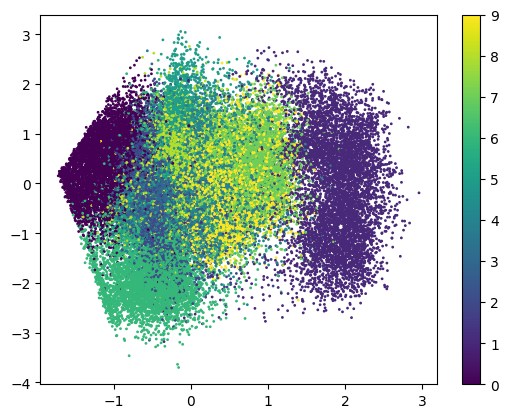

In [280]:
plt.scatter(z[:60000,0], z[:60000,1], c=y_train, s=1)
plt.colorbar() # Epoch 100. DO NO RERUN THIS CELL

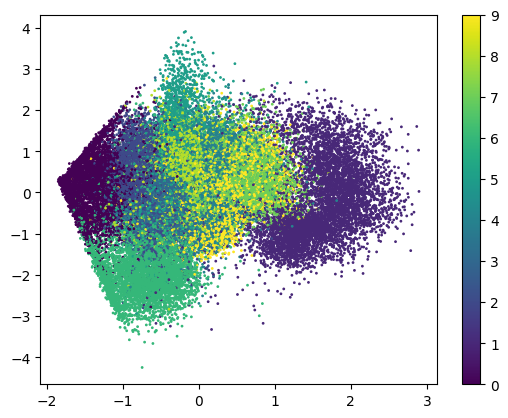

In [293]:
plt.scatter(z[:60000,0], z[:60000,1], c=y_train, s=1)
plt.colorbar() # Epoch 130. DO NO RERUN THIS CELL

In [309]:
scale = 1
mean = 1
n = 32

In [310]:
grid_x = np.linspace(-1.5, 1.5 , n)
grid_y = np.linspace(-1.5, 1, n)
print(grid_x, grid_y)

[-1.5        -1.40322581 -1.30645161 -1.20967742 -1.11290323 -1.01612903
 -0.91935484 -0.82258065 -0.72580645 -0.62903226 -0.53225806 -0.43548387
 -0.33870968 -0.24193548 -0.14516129 -0.0483871   0.0483871   0.14516129
  0.24193548  0.33870968  0.43548387  0.53225806  0.62903226  0.72580645
  0.82258065  0.91935484  1.01612903  1.11290323  1.20967742  1.30645161
  1.40322581  1.5       ] [-1.5        -1.41935484 -1.33870968 -1.25806452 -1.17741935 -1.09677419
 -1.01612903 -0.93548387 -0.85483871 -0.77419355 -0.69354839 -0.61290323
 -0.53225806 -0.4516129  -0.37096774 -0.29032258 -0.20967742 -0.12903226
 -0.0483871   0.03225806  0.11290323  0.19354839  0.27419355  0.35483871
  0.43548387  0.51612903  0.59677419  0.67741935  0.75806452  0.83870968
  0.91935484  1.        ]


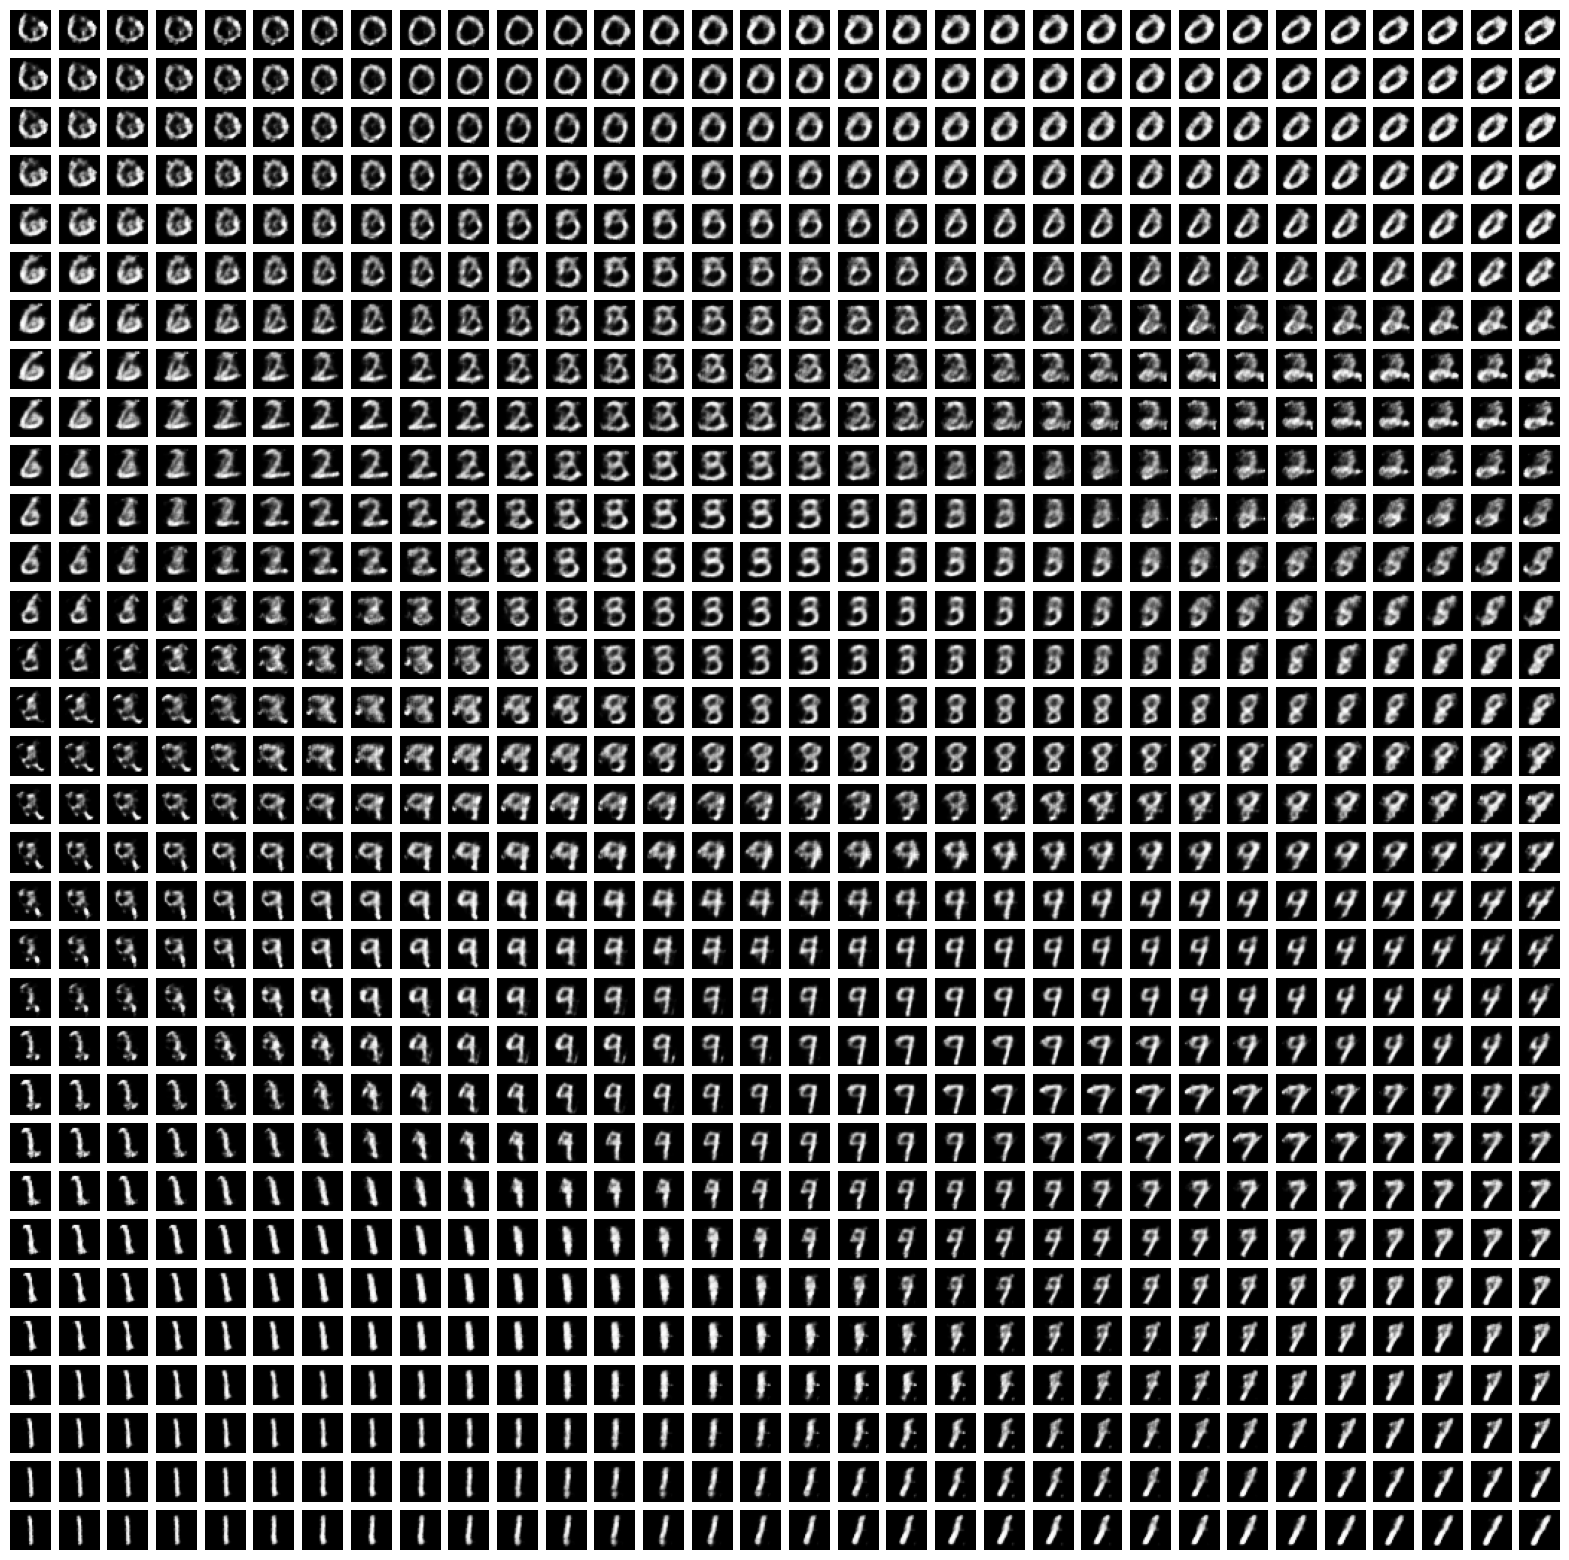

In [311]:
plt.figure(figsize=(20,20))
k=0
for x in grid_x:
    for y in grid_y:
        ax=  plt.subplot(n,n,k+1)
        inp = tf.constant([[x,y]])
        out = decoder(inp)[0][...,0]
        plt.imshow(out, cmap='gray')
        plt.axis('off')
        k +=1

In [265]:
encoder.save("encoder.keras")
encoder.save("encoder.h5")
decoder.save("decoder.keras")
decoder.save("decoder.h5")